In [1]:
import pandas as pd
import pmdarima as pm
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.linear_model import LinearRegression

# 1. Статистические модели прогнозирования. Практика

#### 1.1 Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [2]:
df = pd.read_csv("data/ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [3]:
df_test = df[-3:]
df_train = df[:-3]
print(f'Не вошло в тренировочную выборку {df.shape[0] - df_train.shape[0]} позиции')

Не вошло в тренировочную выборку 3 позиции


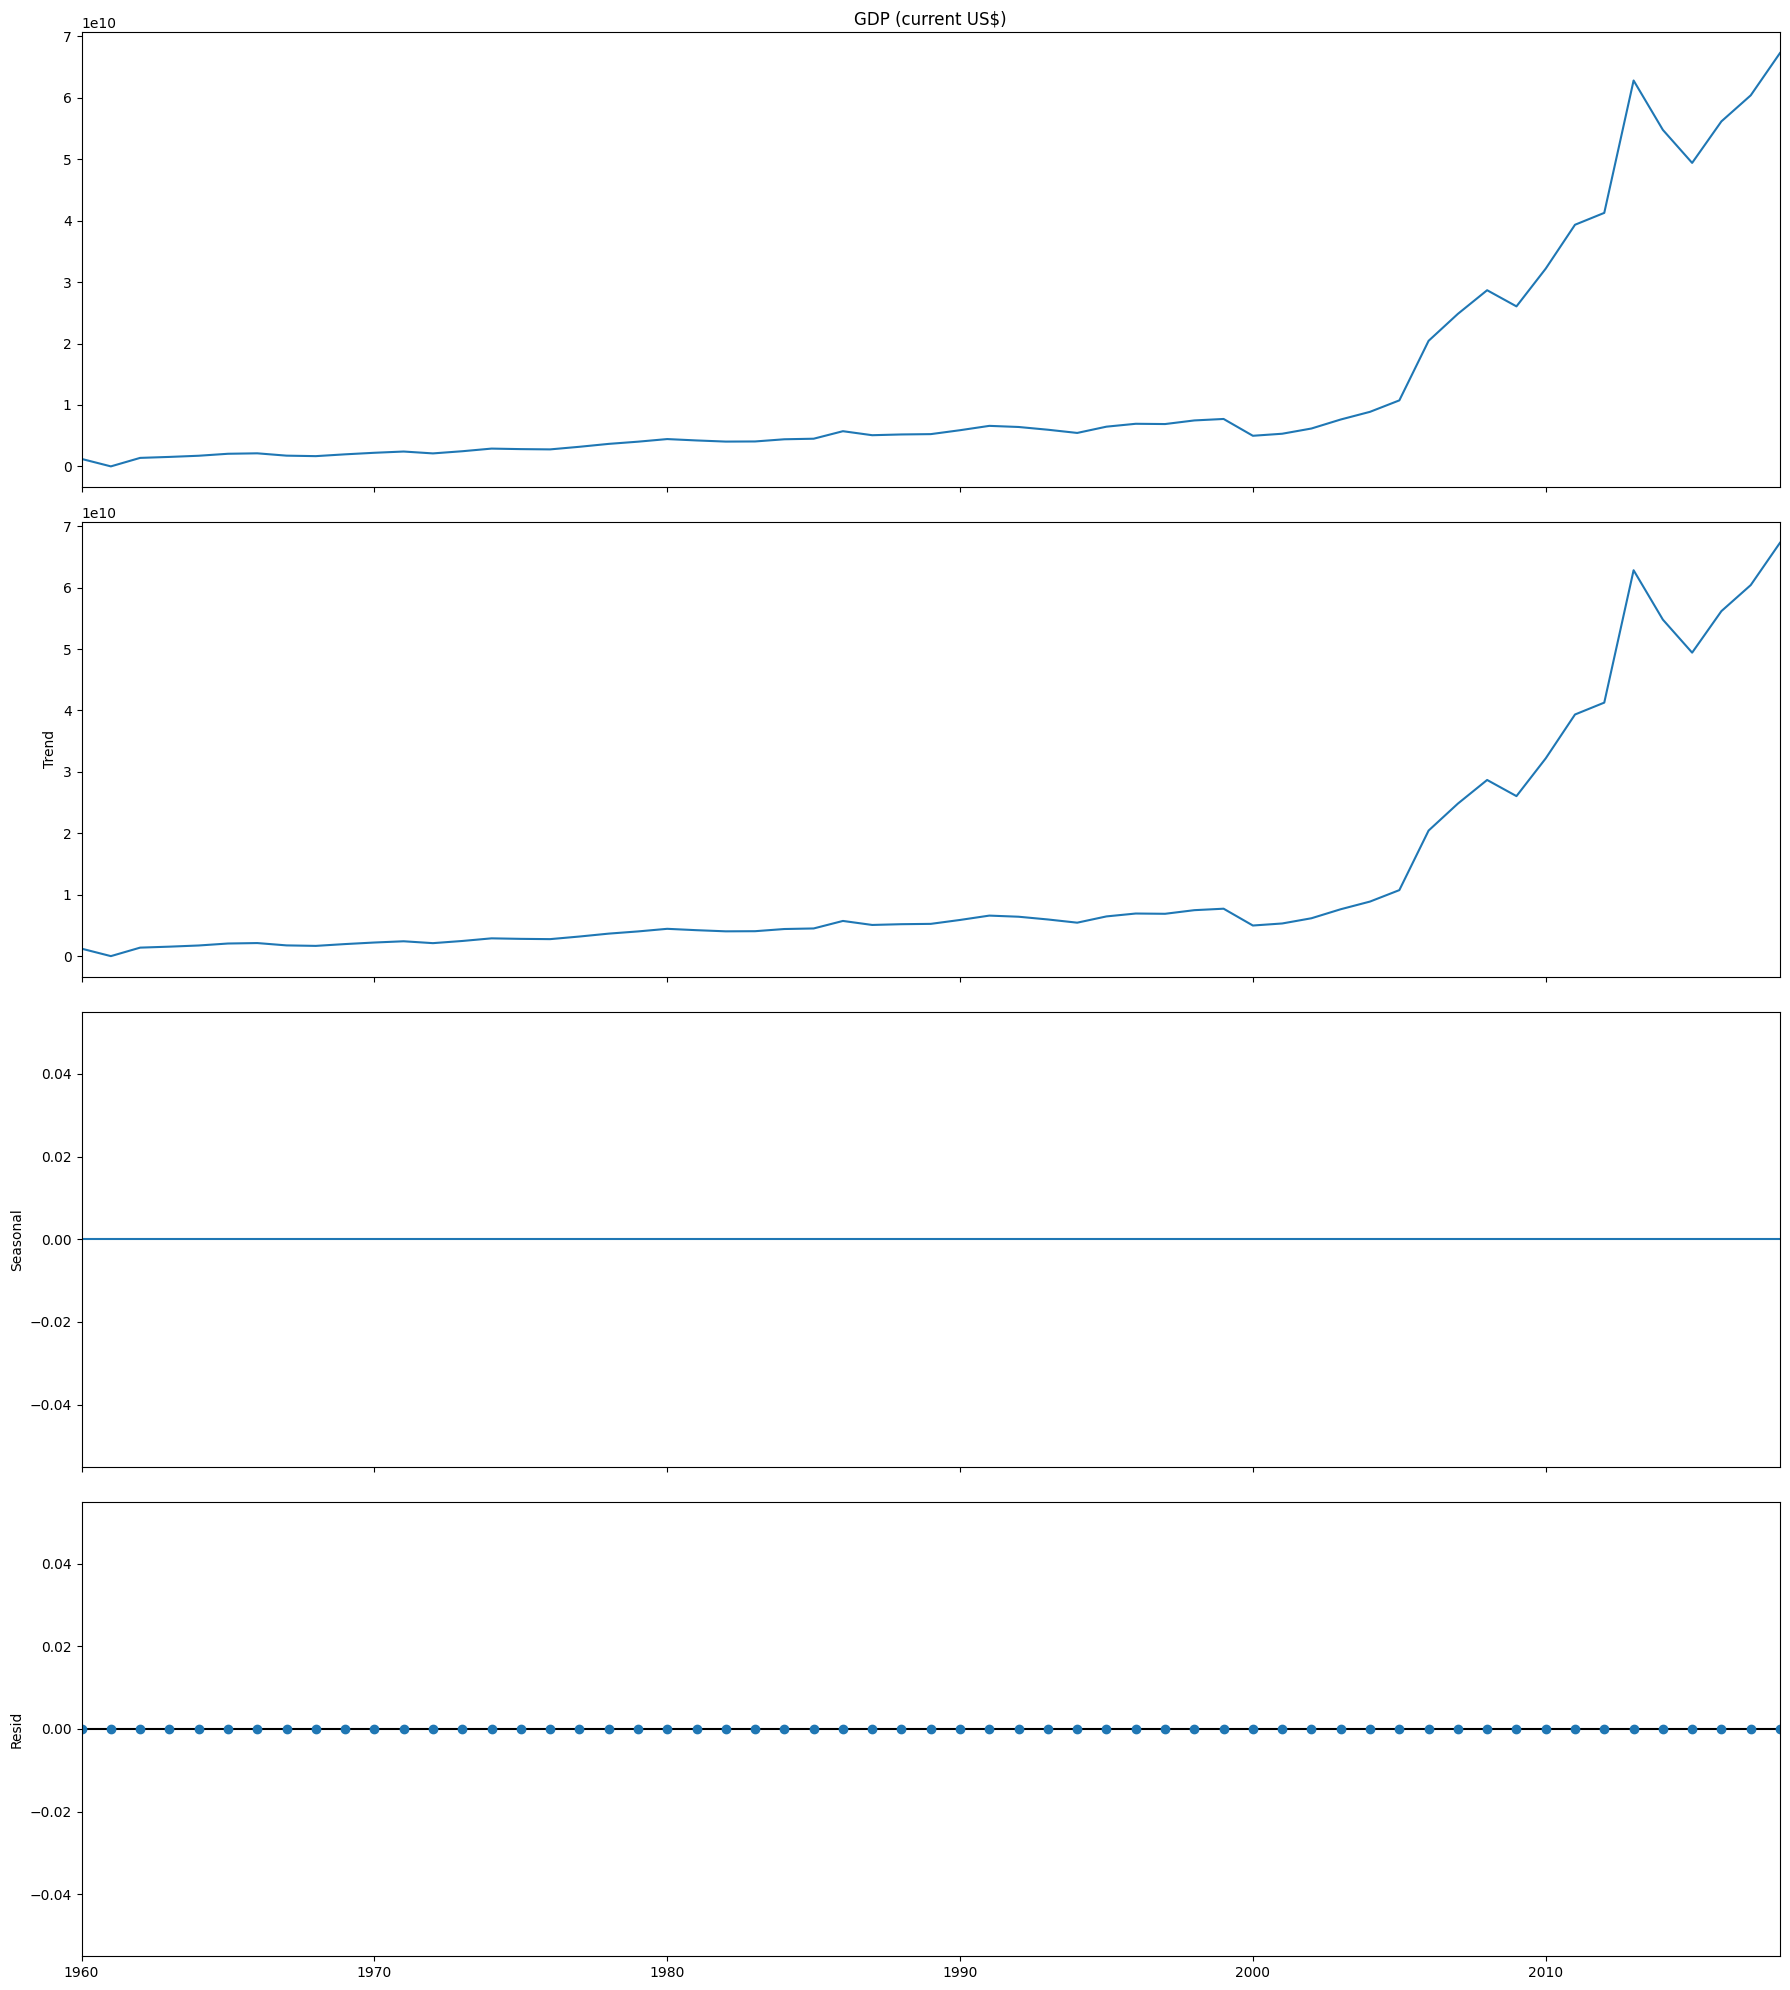

In [4]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(df_train['GDP (current US$)'])
result.plot()
plt.show()

**Вывод:** Поскольку данные имеют небольшое колличество значений, сезонность и шум фактически отсутствуют. Имеем только тренд.

#### 1.2 Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

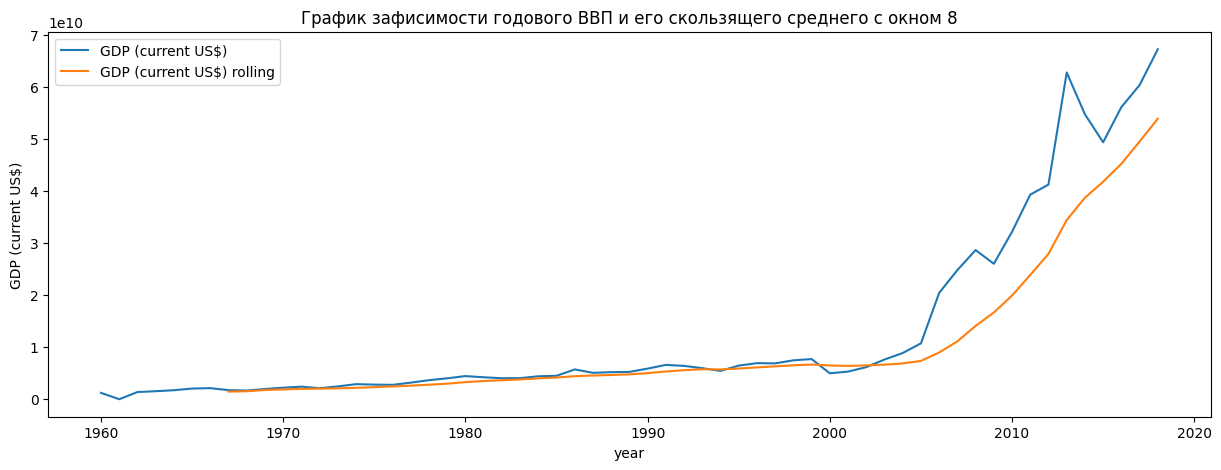

In [5]:
# df_train['GDP (current US$) '] = df_train['GDP (current US$)'].rolling(window=2).mean(),

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df_train);

sns.lineplot(
df_train['GDP (current US$)'].rolling(window=8).mean(),
label= 'GDP (current US$) rolling', 
)

ax.set(title='График зафисимости годового ВВП и его скользящего среднего с окном 8');

#### 1.3 С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [6]:
test1 = adfuller(df_train['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [7]:
flag = True 
diff_count = 0
testing_data = df_train['GDP (current US$)'].diff(periods=1).dropna()

while flag:
    diff_count += 1
    test1 = adfuller(testing_data)
    # print("adf: ", test1[0])
    # print("p-value: ", test1[1])
    # print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print(f"ряд производных {diff_count} степени нестационарен")
        testing_data = testing_data.diff(periods=1).dropna()
    else:
        print(f"ряд производных {diff_count} степени стационарен")
        flag = 0


ряд производных 1 степени нестационарен
ряд производных 2 степени нестационарен
ряд производных 3 степени стационарен


Стационарным будет являться ряд производных третий степени, значит выбираем модель ARIMA.

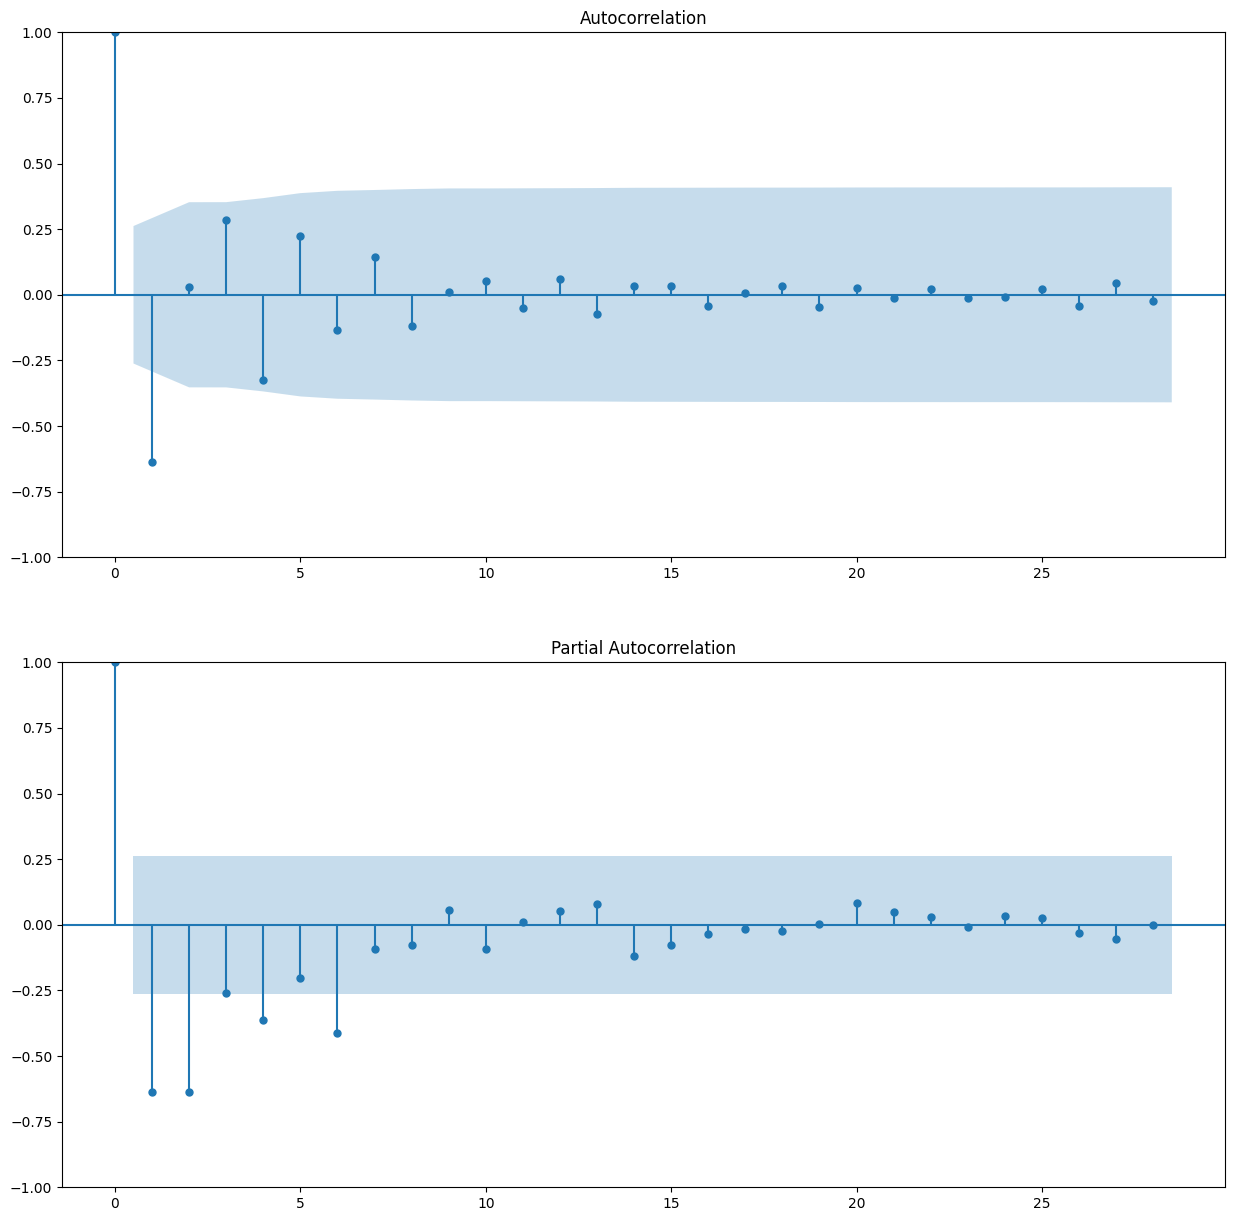

In [8]:
fig, axes = plt.subplots(2, figsize=(15, 15))

ax = sgt.plot_acf(testing_data, ax=axes[0], lags=28)
ax = sgt.plot_pacf(testing_data, ax=axes[1], lags=28, method="ywm")

Определяем p=6, q=8.

In [9]:
arima_model = ARIMA(df_train['GDP (current US$)'].dropna(), order=(6, 3, 8))
arima_model = arima_model.fit()
arima_model.summary()

c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 8)   Log Likelihood               -1299.093
Date:                Tue, 17 Dec 2024   AIC                           2628.186
Time:                        12:29:11   BIC                           2658.566
Sample:                    01-01-1960   HQIC                          2639.964
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5602      0.851     -1.833      0.067      -3.228       0.108
ar.L2         -1.8491      1.379     -1.341      0.180      -4.552       0.854
ar.L3         -1.6291      1.481     -1.100      0.271      -4.531       1.273
ar.L4         -1.5859      1.279     -1.240      0.215      -4.093       0.921
ar.L5         -1.1207      0.853     -1.313      0.189      -2.793       0.552
ar.L6         -0.7356      0.567     -1.297      0.195      -1.847       0.376
ma.L1         -0.3636      1.264     -0.288      0.774      -2.841       2.114
ma.L2         -0.4014      0.839     -0.479      0.632      -2.045       1.243
ma.L3          0.0279      1.450      0.019      0.985      -2.814       2.870
ma.L4         -0.1648      1.686     -0.098      0.922      -3.470       3.141
ma.L5          0.0783      1.367      0.057      0.954      -2.600       2.757
ma.L6          0.1889      1.293      0.146      0.884      -2.345       2.722
ma.L7          0.2364      1.938      0.122      0.903      -3.562       4.035
ma.L8         -0.5923      1.103     -0.537      0.591      -2.755       1.570
sigma2      6.566e+18   6.99e-19    9.4e+36      0.000    6.57e+18    6.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                80.03
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              49.76   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.11e+53. Standard errors may be unstable.
"""

In [10]:
smodel = pm.auto_arima(
    df_train['GDP (current US$)'],
    start_p=1,
    d=3,
    start_q=1,
    max_p=11,
    max_q=11,
    # D=1,
    # start_P=0,
    # m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.71 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.15 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.16 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.05 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.05 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.117 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 17 Dec 2024   AIC                           2659.231
Time:                        12:29:14   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

**Вывод:** Лучше всех паказала модель с построенными вручную с параметрами (6, 3, 8). AIC модели 2628.186

#### 1.4 Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [11]:
df_test_pred = pd.DataFrame(arima_model.predict(start=df_test.index[0], end=df_test.index[-1]), index=df_test.index)
display(df_test_pred)

,predicted_mean
year,
2019-01-01,6.794579e+10
2020-01-01,7.774499e+10
2021-01-01,6.345303e+10


In [12]:
forecast = arima_model.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

df_test_pred.at[df_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
df_test_pred.at[df_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

#### 1.5 Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

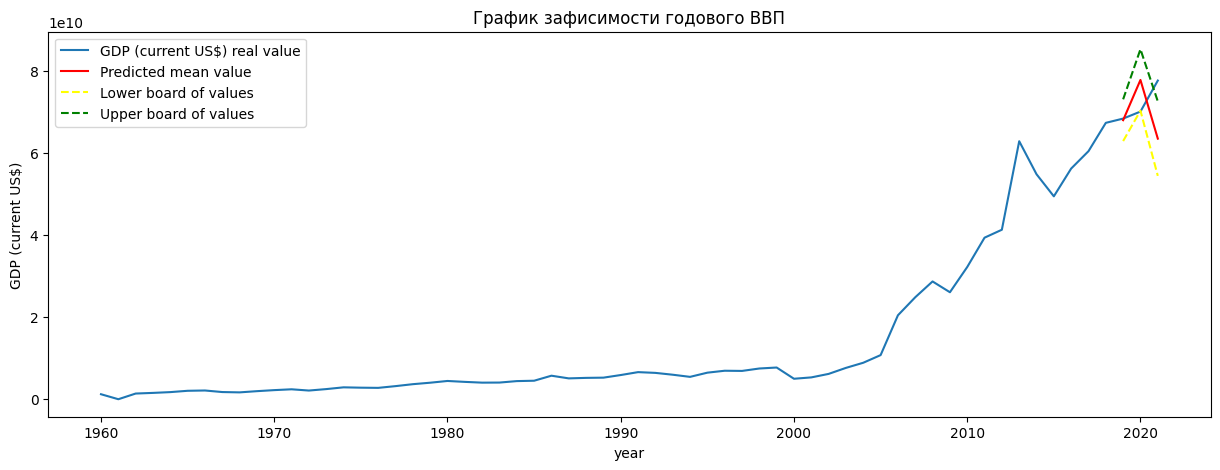

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$)'],
label= 'GDP (current US$) real value')


sns.lineplot(
df_test_pred['predicted_mean'],
label= 'Predicted mean value', 
color='red'
)

sns.lineplot(
df_test_pred['model_preds_lower'],
label= 'Lower board of values', 
color='yellow',
linestyle="--",
)

sns.lineplot(
df_test_pred['model_preds_upper'],
label= 'Upper board of values', 
color='green',
linestyle="--",
)

ax.set(title='График зафисимости годового ВВП');

#### 1.6 Сделайте выводы по полученным результатам.

**Промежуточный вывод:** Прогноз оказался не очень точным. Есть подозрение, что модель уловила сезонность в аномальном росте в 2013 году и попыталась подстроиться под нее. Вижу необходимость попробовать установить значения p и q подобранные pmdarima, хотя их AIC 2659.231 несколько больше

In [14]:
arima_model = ARIMA(df_train['GDP (current US$)'].dropna(), order=(2, 3, 1))
arima_model = arima_model.fit()
arima_model.summary()

c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 17 Dec 2024   AIC                           2659.231
Time:                        12:29:14   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

In [15]:
df_test_pred = pd.DataFrame(arima_model.predict(start=df_test.index[0], end=df_test.index[-1]), index=df_test.index)
display(df_test_pred)

,predicted_mean
year,
2019-01-01,7.368591e+10
2020-01-01,7.954567e+10
2021-01-01,8.633936e+10


In [16]:
forecast = arima_model.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

df_test_pred.at[df_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
df_test_pred.at[df_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

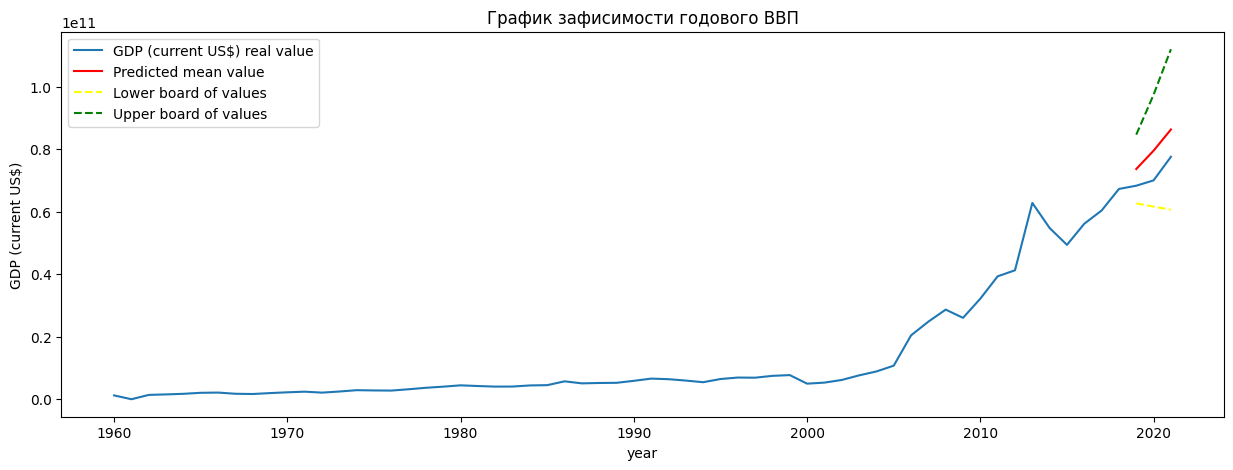

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$)'],
label= 'GDP (current US$) real value')


sns.lineplot(
df_test_pred['predicted_mean'],
label= 'Predicted mean value', 
color='red'
)

sns.lineplot(
df_test_pred['model_preds_lower'],
label= 'Lower board of values', 
color='yellow',
linestyle="--",
)

sns.lineplot(
df_test_pred['model_preds_upper'],
label= 'Upper board of values', 
color='green',
linestyle="--",
)

ax.set(title='График зафисимости годового ВВП');

**Итоговый вывод:** Хотя модель с параметрами (2, 3, 1) и имеет меньшие показатели AIC, но на этом коротком промежутке показала себя лучше (хотя и с большим диапазоном достоверности). Возможно на длинной дистанции появятся большие расхождения с реальным значением. 

# 2. Интерполяция и сэмплирование. Практика

#### 2.1 Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц.

In [18]:
dated = df.asfreq(freq='YS')
print(f'Колличество пропущенных дат - {sum(dated.index != df.index)}')

Колличество пропущенных дат - 0


#### 2.2 Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [19]:
print(f'Количество пропусков в данных - {df.isna().sum().sum()}')

Количество пропусков в данных - 0


#### 2.3 Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

In [20]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [21]:
print(f'Количество пропусков в данных - {df.isna().sum().sum()}')

Количество пропусков в данных - 1


#### 2.4 Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [22]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [23]:
print(f'Количество пропусков в данных - {df.isna().sum().sum()}')

Количество пропусков в данных - 0


#### 2.5 Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

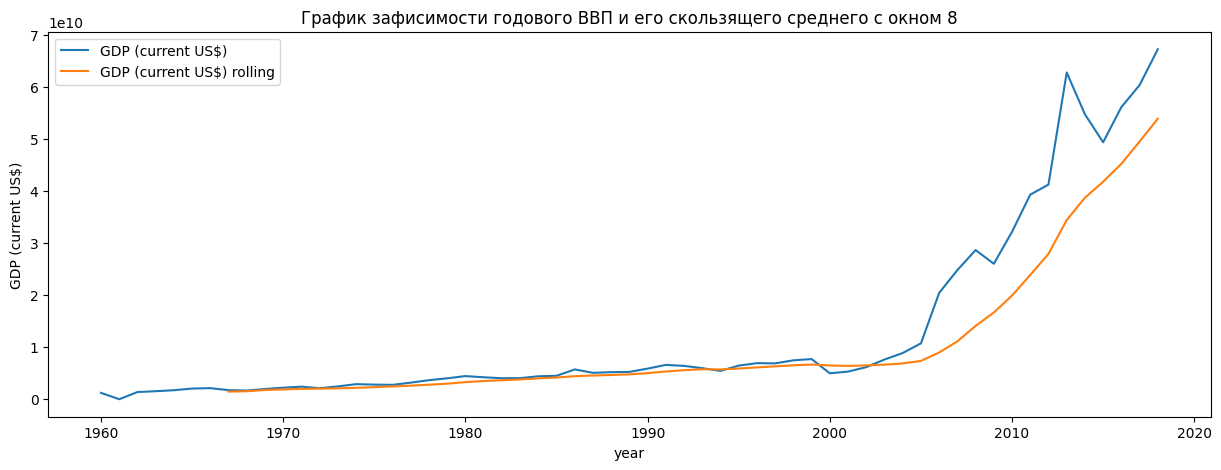

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df_train);

sns.lineplot(
df_train['GDP (current US$)'].rolling(window=8).mean(),
label= 'GDP (current US$) rolling', 
)

ax.set(title='График зафисимости годового ВВП и его скользящего среднего с окном 8');

In [25]:
test1 = adfuller(df_train['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [26]:
flag = True 
diff_count = 0
testing_data = df_train['GDP (current US$)'].diff(periods=1).dropna()

while flag:
    diff_count += 1
    test1 = adfuller(testing_data)
    # print("adf: ", test1[0])
    # print("p-value: ", test1[1])
    # print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print(f"ряд производных {diff_count} степени нестационарен")
        testing_data = testing_data.diff(periods=1).dropna()
    else:
        print(f"ряд производных {diff_count} степени стационарен")
        flag = 0


ряд производных 1 степени нестационарен
ряд производных 2 степени нестационарен
ряд производных 3 степени стационарен


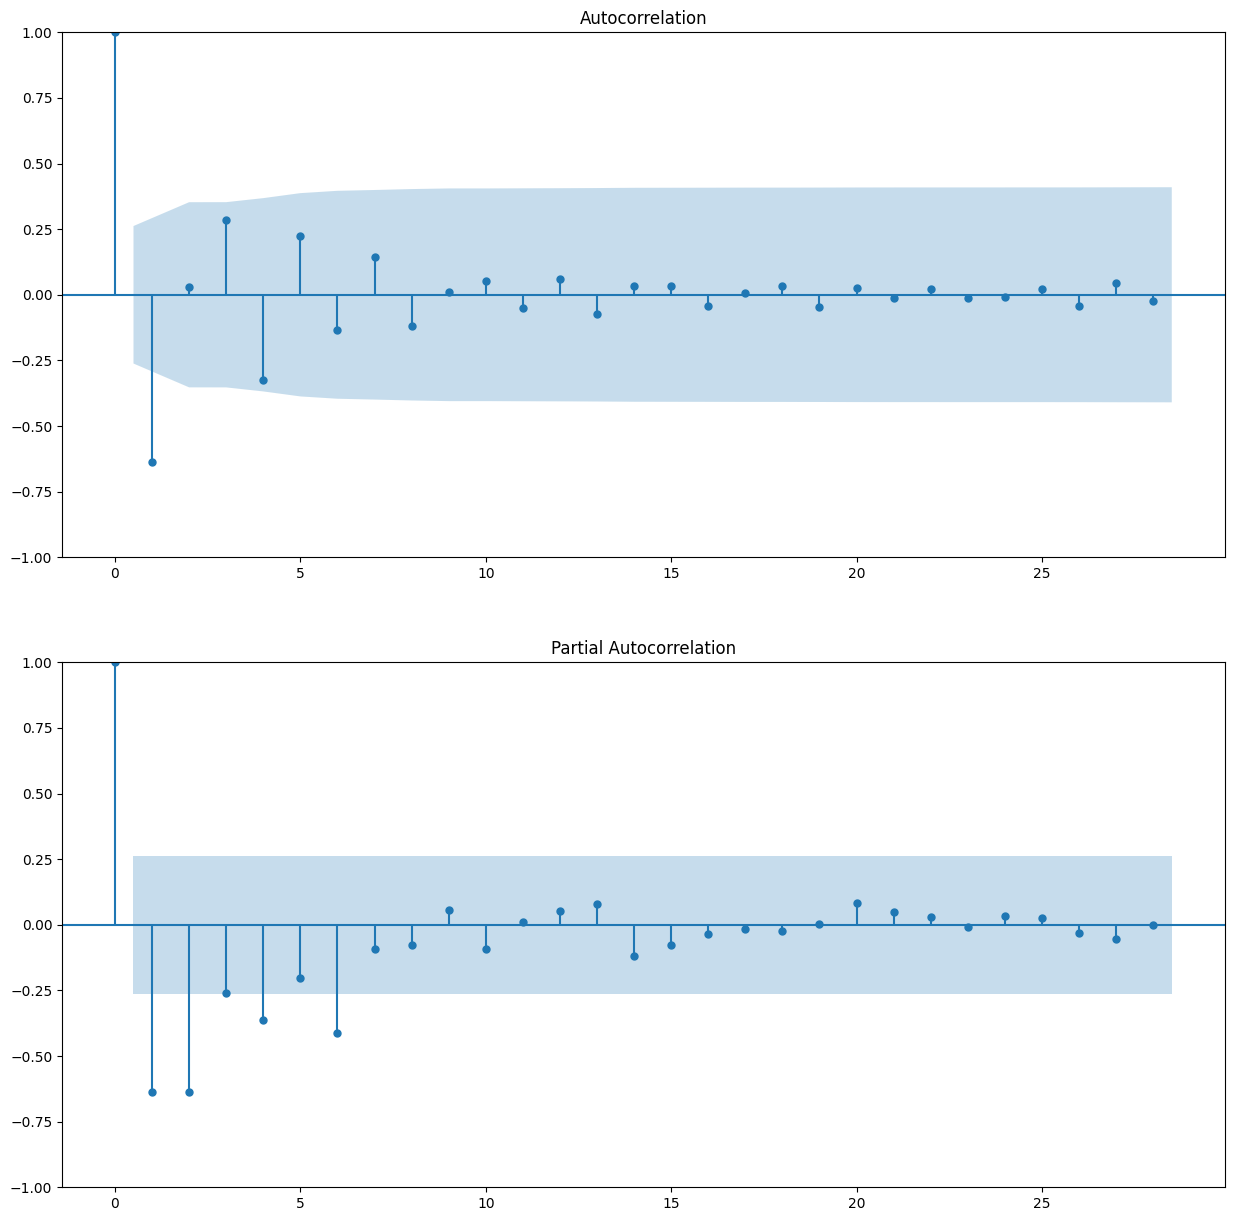

In [27]:
fig, axes = plt.subplots(2, figsize=(15, 15))

ax = sgt.plot_acf(testing_data, ax=axes[0], lags=28)
ax = sgt.plot_pacf(testing_data, ax=axes[1], lags=28, method="ywm")

Попробуем подобрать параметры с помощью pmdarima.

In [28]:
smodel = pm.auto_arima(
    df_train['GDP (current US$)'],
    start_p=1,
    d=3,
    start_q=1,
    max_p=11,
    max_q=11,
    # D=1,
    # start_P=0,
    # m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.11 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.47 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.52 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.64 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.08 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.757 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 17 Dec 2024   AIC                           2659.231
Time:                        12:29:19   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Попробуем повторить построение модели для двух вариантов параметров (6, 3, 8) и (2,3,1).

##### (6, 3, 8)

In [29]:
arima_model = ARIMA(df_train['GDP (current US$)'].dropna(), order=(6, 3, 8))
arima_model = arima_model.fit()
display(arima_model.summary())

df_test_pred = pd.DataFrame(arima_model.predict(start=df_test.index[0], end=df_test.index[-1]), index=df_test.index)

forecast = arima_model.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

df_test_pred.at[df_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
df_test_pred.at[df_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 8)   Log Likelihood               -1299.093
Date:                Tue, 17 Dec 2024   AIC                           2628.186
Time:                        12:29:21   BIC                           2658.566
Sample:                    01-01-1960   HQIC                          2639.964
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5602      0.851     -1.833      0.067      -3.228       0.108
ar.L2         -1.8491      1.379     -1.341      0.180      -4.552       0.854
ar.L3         -1.6291      1.481     -1.100      0.271      -4.531       1.273
ar.L4         -1.5859      1.279     -1.240      0.215      -4.093       0.921
ar.L5         -1.1207      0.853     -1.313      0.189      -2.793       0.552
ar.L6         -0.7356      0.567     -1.297      0.195      -1.847       0.376
ma.L1         -0.3636      1.264     -0.288      0.774      -2.841       2.114
ma.L2         -0.4014      0.839     -0.479      0.632      -2.045       1.243
ma.L3          0.0279      1.450      0.019      0.985      -2.814       2.870
ma.L4         -0.1648      1.686     -0.098      0.922      -3.470       3.141
ma.L5          0.0783      1.367      0.057      0.954      -2.600       2.757
ma.L6          0.1889      1.293      0.146      0.884      -2.345       2.722
ma.L7          0.2364      1.938      0.122      0.903      -3.562       4.035
ma.L8         -0.5923      1.103     -0.537      0.591      -2.755       1.570
sigma2      6.566e+18   6.99e-19    9.4e+36      0.000    6.57e+18    6.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                80.03
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              49.76   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.11e+53. Standard errors may be unstable.
"""

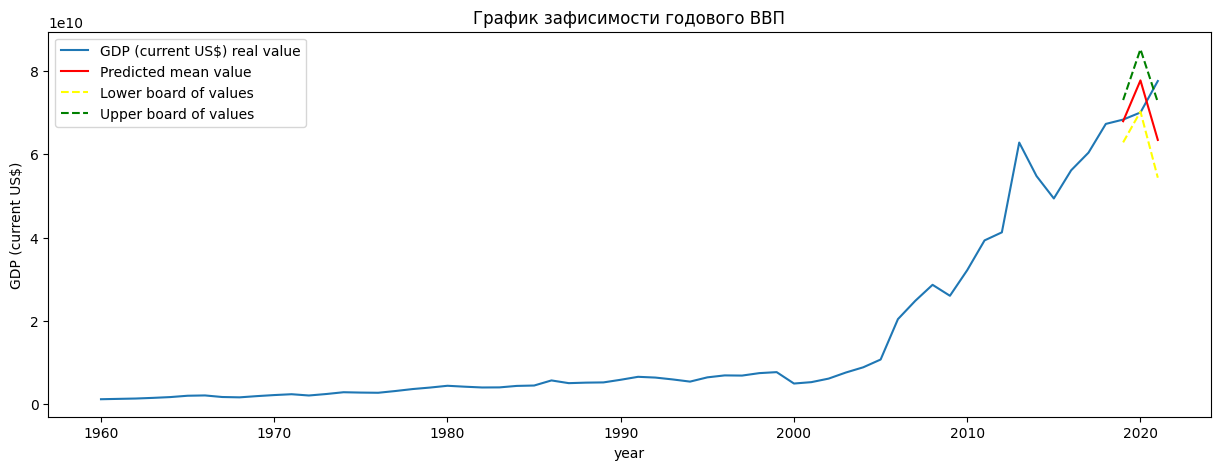

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$)'],
label= 'GDP (current US$) real value')


sns.lineplot(
df_test_pred['predicted_mean'],
label= 'Predicted mean value', 
color='red'
)

sns.lineplot(
df_test_pred['model_preds_lower'],
label= 'Lower board of values', 
color='yellow',
linestyle="--",
)

sns.lineplot(
df_test_pred['model_preds_upper'],
label= 'Upper board of values', 
color='green',
linestyle="--",
)

ax.set(title='График зафисимости годового ВВП');

##### (2, 3, 1)

In [31]:
arima_model = ARIMA(df_train['GDP (current US$)'].dropna(), order=(2, 3, 1))
arima_model = arima_model.fit()
display(arima_model.summary())

df_test_pred = pd.DataFrame(arima_model.predict(start=df_test.index[0], end=df_test.index[-1]), index=df_test.index)

forecast = arima_model.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

df_test_pred.at[df_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
df_test_pred.at[df_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Projects\DS\lessons\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 17 Dec 2024   AIC                           2659.231
Time:                        12:29:22   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

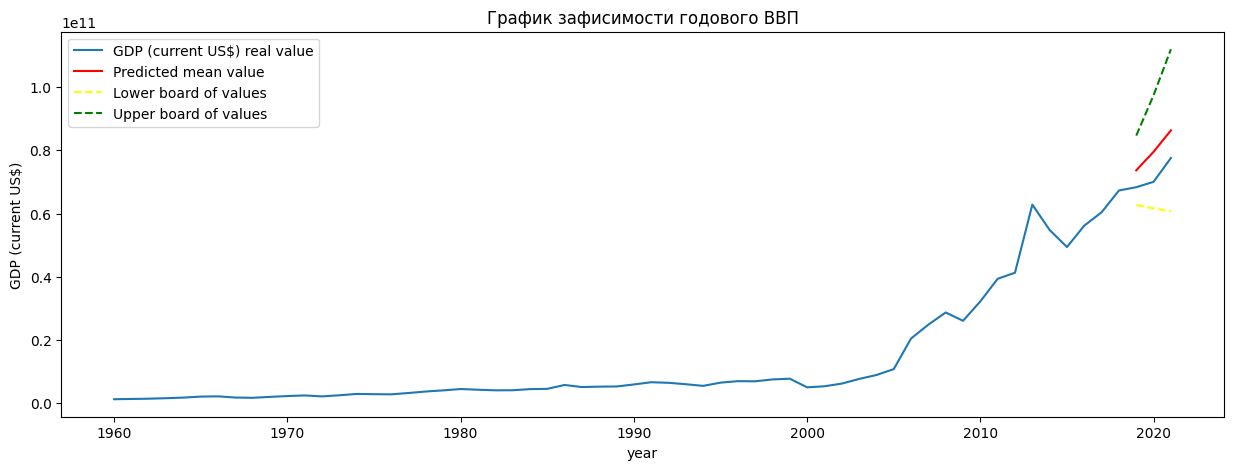

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$)'],
label= 'GDP (current US$) real value')


sns.lineplot(
df_test_pred['predicted_mean'],
label= 'Predicted mean value', 
color='red'
)

sns.lineplot(
df_test_pred['model_preds_lower'],
label= 'Lower board of values', 
color='yellow',
linestyle="--",
)

sns.lineplot(
df_test_pred['model_preds_upper'],
label= 'Upper board of values', 
color='green',
linestyle="--",
)

ax.set(title='График зафисимости годового ВВП');

#### 2.6 Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

**Вывод:** Ни значение AIC ни графики моделей не изменились. Можем сделать вывод что заполнение одного значения не повлияло на модель.

# 3. Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика

#### 3.1 Посчитайте волатильность для вашего временного ряда.

In [33]:
df["GDP (current US$) Vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df["GDP (current US$) Vol"].head()

vol_data = testing_data.pct_change(1).mul(100).abs()
vol_data.head()

year
1963-01-01           NaN
1964-01-01    132.857143
1965-01-01     92.084727
1966-01-01    483.098592
1967-01-01     46.771879
Name: GDP (current US$), dtype: float64

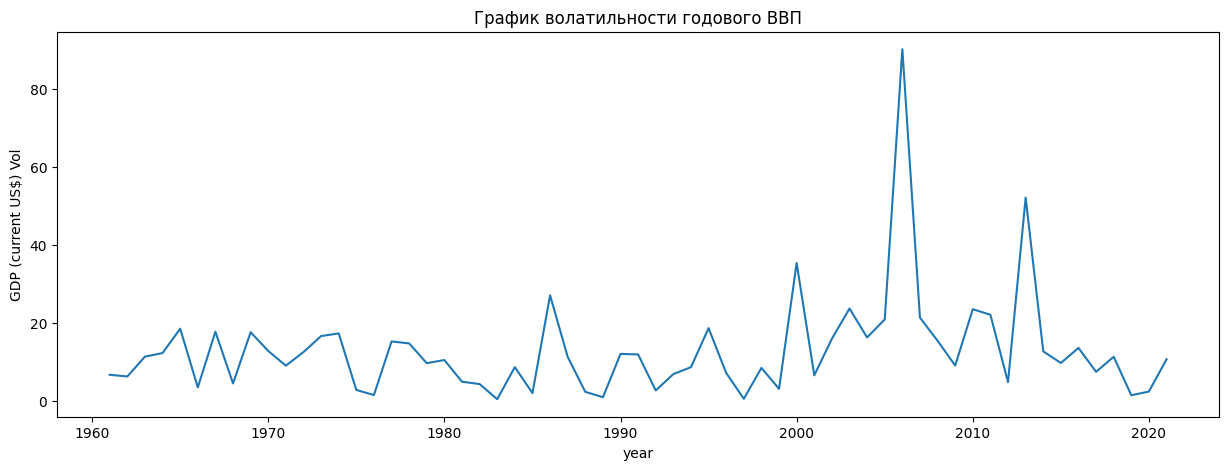

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$) Vol'],
)

ax.set(title='График волатильности годового ВВП');

**Вывод:** Волатильность имеет неравномерное распределение на графике. Возможно и к этой модели имеет смылс применение GARCH модели.

#### 3.2 Используйте GARCH-модель для предсказания волатильности.

In [35]:
garch_df = pd.DataFrame(df["GDP (current US$) Vol"].loc[df.index])


Как и ранее попробуем рассмотреть две модели

##### p=6, q=8

In [36]:
model = arch_model(garch_df['GDP (current US$) Vol'].dropna(), p=6, q=8)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     90,   Neg. LLF: 236.5896551325786
Iteration:     10,   Func. Count:    180,   Neg. LLF: 214.86559474158014
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.44814453159316
Iteration:     20,   Func. Count:    351,   Neg. LLF: 213.4472910543454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.44516422149093
            Iterations: 24
            Function evaluations: 418
            Gradient evaluations: 24


In [37]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$) Vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -213.445
Distribution:                     Normal   AIC:                           458.890
Method:               Maximum Likelihood   BIC:                           491.857
                                           No. Observations:                   58
Date:                   Tue, Dec 17 2024   Df Residuals:                       57
Time:                           12:29:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.3048      1.169      9.667  4.165e-22 [  9.013, 13.597]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         25.8298     32.514      0.794      0.427      [-37.897, 89.557]
alpha[1]       0.0000  8.096e-03      0.000      1.000 [-1.587e-02,1.587e-02]
alpha[2]       0.0000  2.327e-02      0.000      1.000 [-4.561e-02,4.561e-02]
alpha[3]       0.0000  3.907e-02      0.000      1.000 [-7.657e-02,7.657e-02]
alpha[4]   3.7478e-03  9.344e-03      0.401      0.688 [-1.457e-02,2.206e-02]
alpha[5]       0.0000  1.719e-02      0.000      1.000 [-3.369e-02,3.369e-02]
alpha[6]       0.7362      0.353      2.084  3.714e-02    [4.389e-02,  1.428]
beta[1]        0.0815  6.299e-02      1.294      0.196   [-4.193e-02,  0.205]
beta[2]        0.0000  4.290e-02      0.000      1.000 [-8.408e-02,8.408e-02]
beta[3]        0.0000  1.755e-02      0.000      1.000 [-3.440e-02,3.440e-02]
beta[4]        0.0000  5.441e-02      0.000      1.000      [ -0.107,  0.107]
beta[5]        0.0000  4.204e-02      0.000      1.000 [-8.239e-02,8.239e-02]
beta[6]        0.0000  2.055e-02      0.000      1.000 [-4.028e-02,4.028e-02]
beta[7]        0.0000      0.548      0.000      1.000      [ -1.075,  1.075]
beta[8]        0.1786      0.169      1.058      0.290      [ -0.152,  0.509]
=============================================================================

Covariance estimator: robust
"""

In [38]:
predictions_df = df_test.copy()
predictions_df["Predictions GARCH"] = model_results.forecast().variance .loc[
    df_test.index
]

In [39]:
predictions_df

,GDP (current US$),Predictions GARCH
year,,
2019-01-01,6.833754e+10,959.753547
2020-01-01,7.004320e+10,194.209858
2021-01-01,7.759428e+10,75.343585


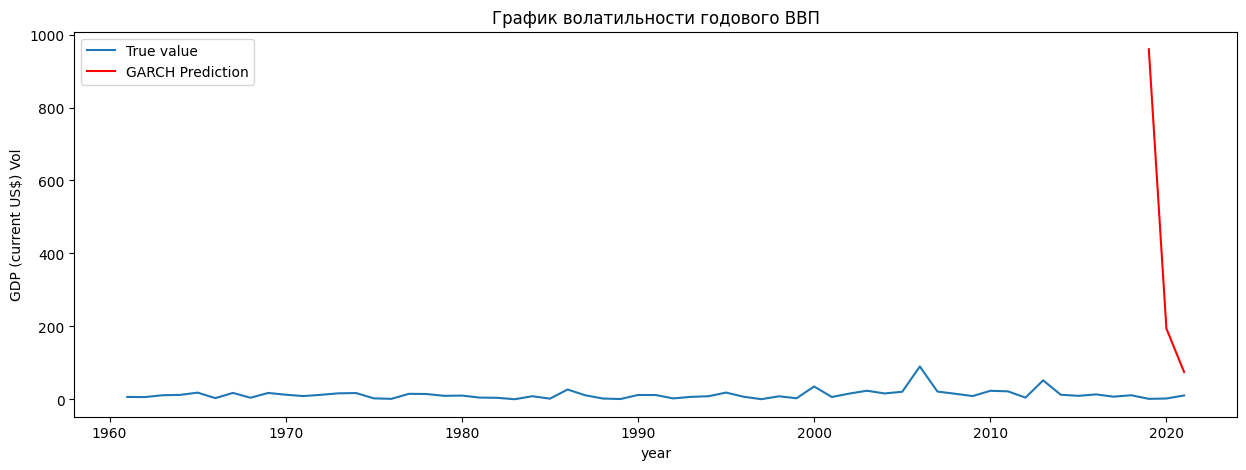

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$) Vol'],
label='True value',
)

sns.lineplot(
predictions_df['Predictions GARCH'],
label='GARCH Prediction',
color='red',
)

ax.set(title='График волатильности годового ВВП');

##### p=2, q=1

In [41]:
model = arch_model(garch_df['GDP (current US$) Vol'].dropna(), p=2, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

model_results.summary()

Iteration:      5,   Func. Count:     32,   Neg. LLF: 265.11687264337854
Iteration:     10,   Func. Count:     67,   Neg. LLF: 234.3647760861566
Iteration:     15,   Func. Count:    101,   Neg. LLF: 227.1855852117777
Iteration:     20,   Func. Count:    131,   Neg. LLF: 226.59781239141685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781239141685
            Iterations: 21
            Function evaluations: 136
            Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$) Vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -226.598
Distribution:                     Normal   AIC:                           463.196
Method:               Maximum Likelihood   BIC:                           473.498
                                           No. Observations:                   58
Date:                   Tue, Dec 17 2024   Df Residuals:                       57
Time:                           12:29:24   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3196      1.921      6.413  1.424e-10 [  8.555, 16.085]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6702     20.946      0.175      0.861 [-37.383, 44.724]
alpha[1]   1.9338e-10  9.317e-02  2.076e-09      1.000 [ -0.183,  0.183]
alpha[2]   1.8104e-10      0.151  1.202e-09      1.000 [ -0.295,  0.295]
beta[1]        1.0000      0.140      7.160  8.091e-13 [  0.726,  1.274]
========================================================================

Covariance estimator: robust
"""

In [42]:
predictions_df = df_test.copy()
predictions_df["Predictions GARCH"] = model_results.forecast().variance .loc[
    df_test.index
]

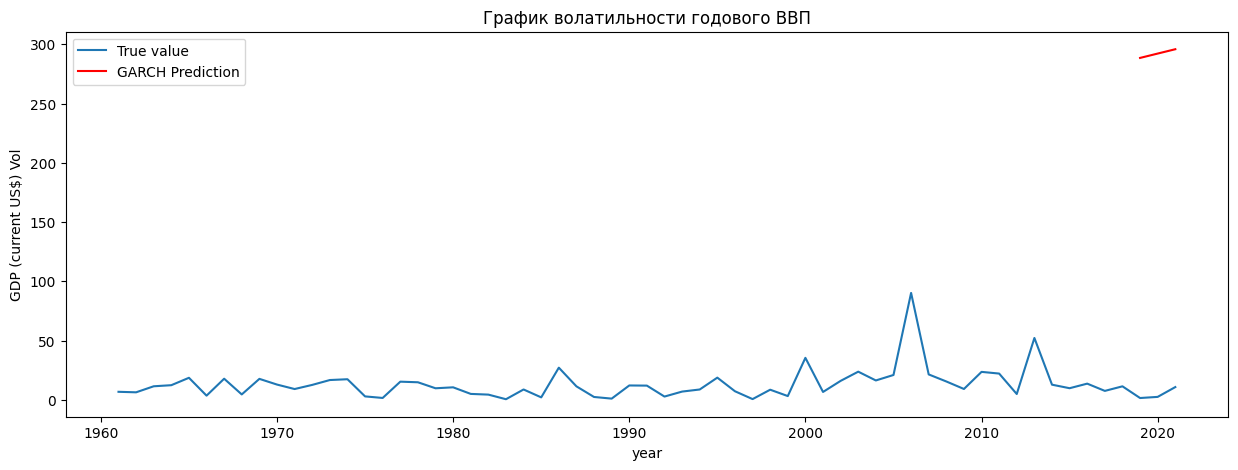

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$) Vol'],
label='True value',
)

sns.lineplot(
predictions_df['Predictions GARCH'],
label='GARCH Prediction',
color='red',
)

ax.set(title='График волатильности годового ВВП');

**Вывод:** Ни одна из моделей не смогла предсказать дисперсию. Возможно применение GARCH моделей для этой задачи не дает преимуществ.

#### 3.3 Используйте линейную регрессию для получения прогноза.

In [44]:
X_train = pd.DataFrame(range(df["GDP (current US$) Vol"].shape[0]))[:-3].fillna(0)
X_test = pd.DataFrame(range(df["GDP (current US$) Vol"].shape[0]))[-3:].fillna(0)
y_train = df["GDP (current US$) Vol"][:-3].fillna(0)
y_test = df["GDP (current US$) Vol"][-3:].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

#### 3.4 Визуализируйте полученное предсказание вместе с фактическим значением.

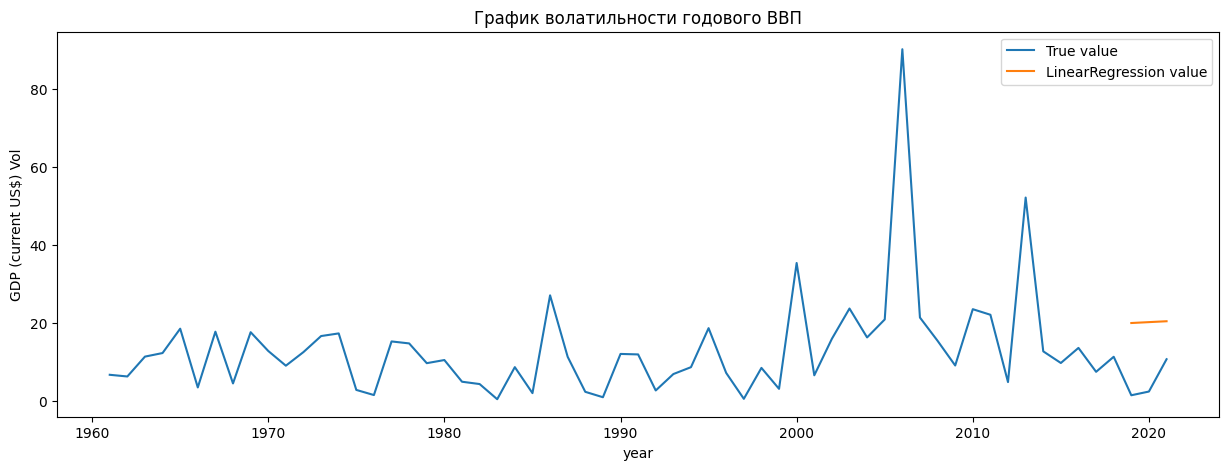

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
df['GDP (current US$) Vol'],
label='True value',
)

sns.lineplot(
y=lr_predict,
x=df_test.index,
label='LinearRegression value',
)

ax.set(title='График волатильности годового ВВП');

#### 3.5-6 Сравните результаты и сделайте выводы. Почему результат модели GARCH получился именно таким?

**Вывод:**  Настолько простое применения линейной регрессии дало лучший результат чем GARCH. Возможно в выборке недостаточно данных чтобы полноценно обучить GARCH модель.